# Way number eight of looking at the correlation coefficient

This is a notebook to accompany the blog post ["Way number eight of looking at the correlation coefficient"](http://composition.al/blog/2019/01/31/way-number-eight-of-looking-at-the-correlation-coefficient/). Read the post for additional context!

In [1]:
import numpy as np
from datascience import *
from datetime import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import math

## Recap from last time

As [before](http://composition.al/blog/2018/08/31/understanding-the-regression-line-with-standard-units/), we're using the [datascience](http://data8.org/datascience/) package, and everything else we're using is pretty standard.

And, as before, here's the data we'll be working with, [converted to standard units](https://www.inferentialthinking.com/chapters/14/2/Variability#standard-units) and plotted:

In [2]:
heightweight = Table().with_columns([
    'Date',        ['07/28/2017', '08/07/2017', '08/25/2017', '09/25/2017', '11/28/2017', '01/26/2018', '04/27/2018', '07/30/2018'],
    'Height (cm)', [        53.3,         54.6,         55.9,           61,         63.5,         67.3,         71.1,         74.9],
    'Weight (kg)', [       4.204,         4.65,        5.425,         6.41,        7.985,        9.125,        10.39,       10.785],
                                    ])
def standard_units(nums):
    return (nums - np.mean(nums)) / np.std(nums)

heightweight_standard = Table().with_columns(
    'Date', heightweight.column('Date'),
    'Height (standard units)', standard_units(heightweight.column('Height (cm)')),
    'Weight (standard units)', standard_units(heightweight.column('Weight (kg)')))
heightweight_standard

Date,Height (standard units),Weight (standard units)
07/28/2017,-1.26135,-1.3158
08/07/2017,-1.08691,-1.13054
08/25/2017,-0.912464,-0.808628
09/25/2017,-0.228116,-0.399485
11/28/2017,0.107349,0.254728
01/26/2018,0.617255,0.728253
04/27/2018,1.12716,1.2537
07/30/2018,1.63707,1.41777


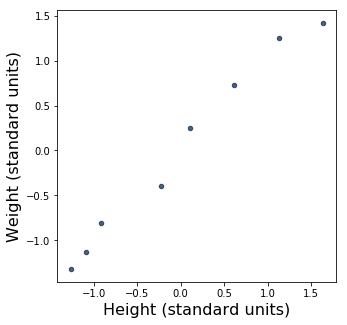

In [3]:
heightweight_standard.scatter(
    'Height (standard units)',
    'Weight (standard units)')

## Visualizing the data in "person space"

So far, this is all a recap of [last time](http://composition.al/blog/2018/08/31/understanding-the-regression-line-with-standard-units/).  Now, let's try turning our data sideways.

The hacky way I have of doing this is to convert the data first to a numpy [ndarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html), then to a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), and then [transposing](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.T.html#pandas.DataFrame.T) the DataFrame.  This is kind of silly, but I don't know a better way to transpose a [structured ndarray](https://docs.scipy.org/doc/numpy/user/basics.rec.html).  If you do, let me know.

In [4]:
# First convert to a plain old numpy ndarray.
heightweight_standard_np = heightweight_standard.to_array()

# Now convert *that* to a pandas DataFrame.
df = pd.DataFrame(heightweight_standard_np)

# Get the transpose of the DataFrame.
df = df.T
df

,0,1,2,3,4,5,6,7
Date,07/28/2017,08/07/2017,08/25/2017,09/25/2017,11/28/2017,01/26/2018,04/27/2018,07/30/2018
Height (standard units),-1.26135,-1.08691,-0.912464,-0.228116,0.107349,0.617255,1.12716,1.63707
Weight (standard units),-1.3158,-1.13054,-0.808628,-0.399485,0.254728,0.728253,1.2537,1.41777


pandas defaults to using `RangeIndex (0, 1, 2, …, n)` for the column labels, but we want the dates from the first row to be the column headers rather than being an actual row.  That's [an easy change to make](https://stackoverflow.com/questions/26147180/convert-row-to-column-header-for-pandas-dataframe), though.

In [5]:
df.columns = df.iloc[0]
df = df.drop("Date")
df

Date,07/28/2017,08/07/2017,08/25/2017,09/25/2017,11/28/2017,01/26/2018,04/27/2018,07/30/2018
Height (standard units),-1.26135,-1.08691,-0.912464,-0.228116,0.107349,0.617255,1.12716,1.63707
Weight (standard units),-1.3158,-1.13054,-0.808628,-0.399485,0.254728,0.728253,1.2537,1.41777


While we're at it, we'll convert the values in our DataFrame to numeric values, so that we can visualize them in a moment.

In [6]:
df = df.apply(pd.to_numeric)
df

Date,07/28/2017,08/07/2017,08/25/2017,09/25/2017,11/28/2017,01/26/2018,04/27/2018,07/30/2018
Height (standard units),-1.261347,-1.086906,-0.912464,-0.228116,0.107349,0.617255,1.127161,1.637068
Weight (standard units),-1.315798,-1.130542,-0.808628,-0.399485,0.254728,0.728253,1.253700,1.417773


Eight dimensions are too many to try to visualize, but we can pare it down to three.  We'll pick three -- the first (07/28/2017), the last (07/30/2018), and one in the middle (01/26/2018) -- and drop the rest.

In [7]:
df_3dim = df.drop(df.columns[[1, 2, 3, 4, 6]],axis=1)
df_3dim

Date,07/28/2017,01/26/2018,07/30/2018
Height (standard units),-1.261347,0.617255,1.637068
Weight (standard units),-1.315798,0.728253,1.417773


Now we can visualize the data with a three-dimensional scatter plot.

<IPython.core.display.Javascript object>


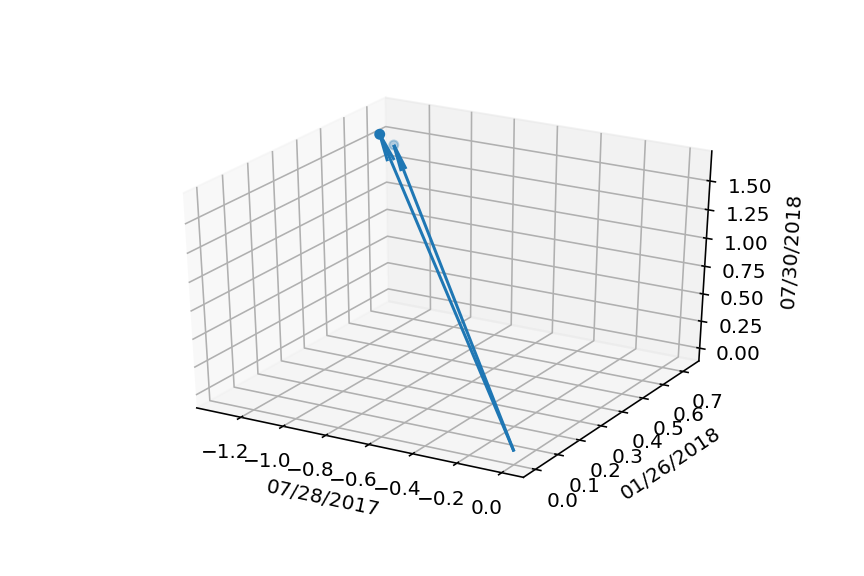

In [9]:
%matplotlib notebook
scatter_3d = plots.figure().gca(projection='3d')
scatter_3d.scatter(df_3dim.iloc[:, 0], df_3dim.iloc[:, 1], df_3dim.iloc[:, 2])
scatter_3d.set_xlabel(df_3dim.columns[0])
scatter_3d.set_ylabel(df_3dim.columns[1])
scatter_3d.set_zlabel(df_3dim.columns[2])
height_point = df_3dim.iloc[0]
weight_point = df_3dim.iloc[1]
origin = [0,0,0]

X, Y, Z = zip(origin,origin) 
U, V, W = zip(height_point, weight_point)

scatter_3d.quiver(X, Y, Z, U, V, W, arrow_length_ratio=0.09)

plots.show()

What's going on here?  We're in the "person space", where, as Rodgers and Nicewander explained, each axis represents an observation -- in this case, three observations.  And there are two points, as promised -- one for each of height and weight.

If we look at the difference between the two points on the z-axis -- that is, the axis for 07/30/2018 -- the darker-colored blue dot is higher up, so it must represent the height variable, with coordinates (-1.26135, 0.617255, 1.63707)  That means that the other, lighter-colored blue dot, with coordinates (-1.3158, 0.728253, 1.41777), must represent the weight variable.

I've also plotted vectors going from the origin to each point.  These are the "variable vectors" for the two points.

## The angle between the variable vectors

Finally, we want to figure out the angle between the two vectors.  There are [various ways](https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python) to do that in Python; we'll use a simple one that works for us:

In [10]:
def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

angle_between_vvs = angle(height_point, weight_point)
angle_between_vvs

0.11140728370937446

Finally, we can take the cosine of that to get the correlation coefficient $r$:

In [11]:
math.cos(angle_between_vvs)

0.9938006245545371

Almost 1!  That means that, just like [last time](http://composition.al/blog/2018/08/31/understanding-the-regression-line-with-standard-units/), we have an almost perfect linear correlation.

It's a bit different from what we had last time, though, which was 0.9910523777994954.  That's because, for the sake of visualization, we decided to only look at three of the observations.

## The angle between the _actual_ variable vectors

We can, however, go back to all eight dimensions.  We may not be able to visualize them, but we can still measure the angle between them!

In [12]:
height_point_8dim = df.iloc[0]
weight_point_8dim = df.iloc[1]
angle_between_8dim_vvs = angle(height_point_8dim, weight_point_8dim)
angle_between_8dim_vvs

0.1338730551963976

Taking the cosine of this slightly bigger angle:

In [13]:
math.cos(angle_between_8dim_vvs)

0.9910523777994951

This turns out to be the same as what we had previously calculated $r$ to be, modulo a little numerical imprecision.  And so, that's way number eight of looking at the correlation coefficient -- as the angle between two variable vectors in "person space".